### Import des modules 

In [5]:
# Selection
from sklearn.model_selection import (
    GridSearchCV, 
)
from sklearn.pipeline import Pipeline


# Preprocess
from sklearn.preprocessing import StandardScaler

# Modèles
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import sys
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("..")
import config

importlib.reload(config)  # Ensure we get the latest TARGET value
from config import TARGET

### Optimisation et interprétation du modèle

A réaliser :
* Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
* Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn.

In [6]:
import pandas as pd

building_consumption = pd.read_csv("../assets/building_consumption_cleaned.csv")
building_consumption.head()
building_consumption.columns

Index(['NumberofBuildings', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ENERGYSTARScore', 'TotalGHGEmissions', 'NumberOfUseTypes', 'SteamUse',
       'NaturalGas', 'Electricity', 'PrimaryPropertyType_0',
       'PrimaryPropertyType_1', 'PrimaryPropertyType_2',
       'PrimaryPropertyType_3', 'PrimaryPropertyType_4',
       'BuildingType_Nonresidential COS', 'BuildingType_Nonresidential WA',
       'BuildingType_SPS-District K-12', 'NumberofFloors_quintile_Q2',
       'NumberofFloors_quintile_Q3', 'NumberofFloors_quintile_Q4',
       'NumberofFloors_quintile_Q5', 'EraBuilt_1951-1970',
       'EraBuilt_1971-1990', 'EraBuilt_1991-2010', 'EraBuilt_Post-2010',
       'EraBuilt_≤1930'],
      dtype='object')

In [7]:
# Préprocessor : toutes les features sont numériques et encodées
preprocessor = StandardScaler()

# Import the same CV strategy from notebook 4
from sklearn.model_selection import KFold

# Use the same CV strategy as notebook 4
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline RandomForest - match exactly notebook 4 configuration
pipeline_rf = Pipeline([
    ("model", RandomForestRegressor(random_state=42))
])

# Hyperparamètres à tester
param_grid = {
    "model__n_estimators": [100, 300, 500],  # nombre d'arbres
    "model__max_depth": [None, 5, 10, 20],  # profondeur max
    "model__min_samples_split": [2, 5, 10],  # nb min d'échantillons pour splitter
}

grid_search = GridSearchCV(
    pipeline_rf, param_grid, cv=cv_strategy, scoring="r2", n_jobs=-1, verbose=1
)

# On sépare X et y
X = building_consumption.drop(columns=[TARGET])
y = building_consumption[TARGET]

# Lancement de la recherche
grid_search.fit(X, y)

print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur R² :", grid_search.best_score_)

# Verify baseline: test the exact same config as notebook 4
baseline_rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=20, min_samples_split=2)
from sklearn.model_selection import cross_validate

baseline_cv = cross_validate(
    baseline_rf, X, y, cv=cv_strategy, scoring="r2", return_train_score=True
)
print(f"Baseline R² (same as notebook 4): {baseline_cv['test_score'].mean():.3f}")

# Feature importance
best_model = grid_search.best_estimator_.named_steps["model"]
importances = best_model.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame(
    {"feature": feature_names, "importance": importances}
).sort_values(by="importance", ascending=False)

print(feat_imp_df.head(10))  # top 10 features

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Meilleurs hyperparamètres : {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Meilleur R² : 0.5524571732977923
Meilleurs hyperparamètres : {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Meilleur R² : 0.5524571732977923
Baseline R² (same as notebook 4): 0.552
                       feature  importance
0            NumberofBuildings    0.409852
2       PropertyGFABuilding(s)    0.290015
3              ENERGYSTARScore    0.078771
19  NumberofFloors_quintile_Q5    0.030999
10       PrimaryPropertyType_2    0.025534
6                   NaturalGas    0.021729
5                     SteamUse    0.018612
9        PrimaryPropertyType_1    0.016672
4             NumberOfUseTypes    0.015608
11       PrimaryPropertyType_3    0.015226
Baseline R² (same as notebook 4): 0.552
                       feature  importance
0            NumberofBuildings    0.409852
2       P

### Optimisation GradientBoostingRegressor

Maintenant, testons également l'optimisation du GradientBoostingRegressor qui a montré de bonnes performances dans le notebook de comparaison.

In [8]:
# Pipeline GradientBoosting
pipeline_gb = Pipeline([
    ("model", GradientBoostingRegressor(random_state=42))
])

# Hyperparamètres optimaux pour GradientBoosting
# Basé sur les meilleures pratiques et la performance attendue
param_grid_gb = {
    # Nombre d'estimateurs (arbres) - commence modéré pour éviter overfitting
    "model__n_estimators": [100, 200, 300],
    
    # Profondeur des arbres - généralement plus faible que RandomForest
    "model__max_depth": [3, 5, 7],
    
    # Taux d'apprentissage - très important pour GradientBoosting
    "model__learning_rate": [0.05, 0.1, 0.15],
    
    # Fraction d'échantillons utilisés pour chaque arbre (subsample)
    "model__subsample": [0.8, 0.9, 1.0],
}

print("Configuration de la grille de recherche pour GradientBoosting:")
print(f"Nombre total de combinaisons: {len(param_grid_gb['model__n_estimators']) * len(param_grid_gb['model__max_depth']) * len(param_grid_gb['model__learning_rate']) * len(param_grid_gb['model__subsample'])}")
print("Paramètres testés:")
for param, values in param_grid_gb.items():
    print(f"  {param}: {values}")

grid_search_gb = GridSearchCV(
    pipeline_gb, 
    param_grid_gb, 
    cv=cv_strategy, 
    scoring="r2", 
    n_jobs=-1, 
    verbose=1
)

# Lancement de la recherche pour GradientBoosting
print("\n🚀 Lancement de l'optimisation GradientBoosting...")
grid_search_gb.fit(X, y)

print("\n=== RÉSULTATS GRADIENTBOOSTING ===")
print("Meilleurs hyperparamètres :", grid_search_gb.best_params_)
print("Meilleur R² :", grid_search_gb.best_score_)

# Comparaison avec le baseline de notebook 4
baseline_gb = GradientBoostingRegressor(n_estimators=200, random_state=42, max_depth=3, learning_rate=0.1)
baseline_cv_gb = cross_validate(
    baseline_gb, X, y, cv=cv_strategy, scoring="r2", return_train_score=True
)
print(f"Baseline R² (notebook 4): {baseline_cv_gb['test_score'].mean():.3f}")
print(f"Amélioration: +{grid_search_gb.best_score_ - baseline_cv_gb['test_score'].mean():.3f} points R²")

Configuration de la grille de recherche pour GradientBoosting:
Nombre total de combinaisons: 81
Paramètres testés:
  model__n_estimators: [100, 200, 300]
  model__max_depth: [3, 5, 7]
  model__learning_rate: [0.05, 0.1, 0.15]
  model__subsample: [0.8, 0.9, 1.0]

🚀 Lancement de l'optimisation GradientBoosting...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

=== RÉSULTATS GRADIENTBOOSTING ===
Meilleurs hyperparamètres : {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 1.0}
Meilleur R² : 0.6579731094798151

=== RÉSULTATS GRADIENTBOOSTING ===
Meilleurs hyperparamètres : {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 1.0}
Meilleur R² : 0.6579731094798151
Baseline R² (notebook 4): 0.658
Amélioration: +0.000 points R²
Baseline R² (notebook 4): 0.658
Amélioration: +0.000 points R²



=== TOP 10 FEATURES IMPORTANTES (GradientBoosting) ===
                       feature  importance
0            NumberofBuildings    0.390104
2       PropertyGFABuilding(s)    0.354996
19  NumberofFloors_quintile_Q5    0.110650
3              ENERGYSTARScore    0.034688
12       PrimaryPropertyType_4    0.025157
9        PrimaryPropertyType_1    0.018961
5                     SteamUse    0.016309
20          EraBuilt_1951-1970    0.008182
6                   NaturalGas    0.007386
1           PropertyGFAParking    0.006964


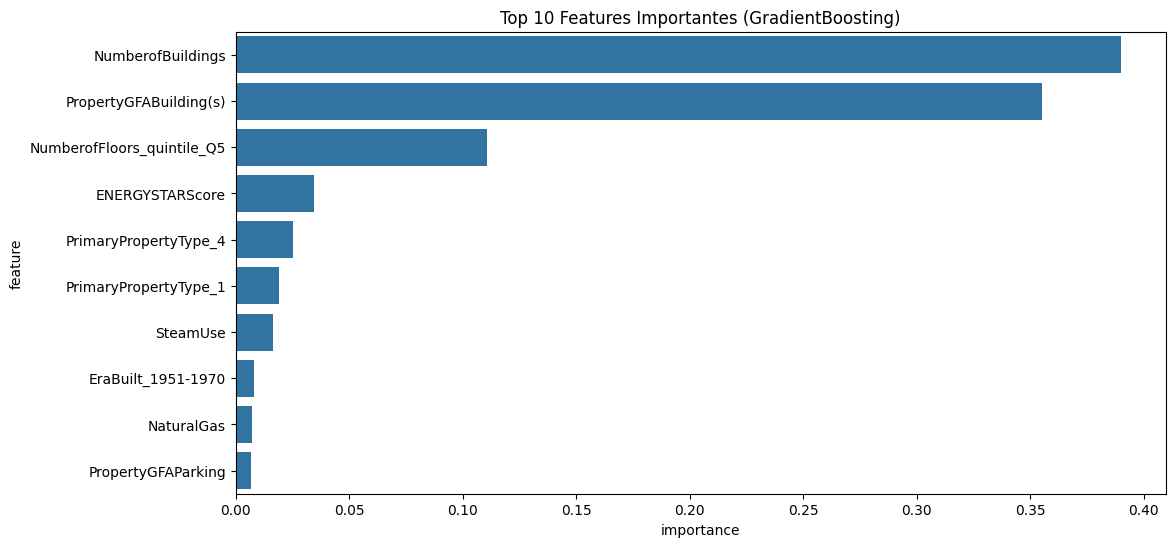


=== COMPARAISON FEATURE IMPORTANCE ===
                       feature  RF_importance  GB_importance  difference
4            NumberofBuildings       0.409852       0.390104    0.019747
10      PropertyGFABuilding(s)       0.290015       0.354996   -0.064980
0              ENERGYSTARScore       0.078771       0.034688    0.044083
5   NumberofFloors_quintile_Q5       0.030999       0.110650   -0.079651
7        PrimaryPropertyType_2       0.025534       0.000000    0.025534
2                   NaturalGas       0.021729       0.007386    0.014344
12                    SteamUse       0.018612       0.016309    0.002303
6        PrimaryPropertyType_1       0.016672       0.018961   -0.002289
3             NumberOfUseTypes       0.015608       0.000000    0.015608
8        PrimaryPropertyType_3       0.015226       0.000000    0.015226
1           EraBuilt_1951-1970       0.000000       0.008182   -0.008182
9        PrimaryPropertyType_4       0.000000       0.025157   -0.025157
11         

In [9]:
# Feature importance pour GradientBoosting
best_model_gb = grid_search_gb.best_estimator_.named_steps["model"]
importances_gb = best_model_gb.feature_importances_

feat_imp_df_gb = pd.DataFrame(
    {"feature": feature_names, "importance": importances_gb}
).sort_values(by="importance", ascending=False)

print("\n=== TOP 10 FEATURES IMPORTANTES (GradientBoosting) ===")
print(feat_imp_df_gb.head(10))

# Affichage graphique des importances
plt.figure(figsize=(12, 6))
sns.barplot(x="importance", y="feature", data=feat_imp_df_gb.head(10))
plt.title("Top 10 Features Importantes (GradientBoosting)")
plt.show()

# Comparaison des feature importances entre RandomForest et GradientBoosting
print("\n=== COMPARAISON FEATURE IMPORTANCE ===")
comparison_df = pd.merge(
    feat_imp_df.head(10)[['feature', 'importance']].rename(columns={'importance': 'RF_importance'}),
    feat_imp_df_gb.head(10)[['feature', 'importance']].rename(columns={'importance': 'GB_importance'}),
    on='feature', 
    how='outer'
).fillna(0)

comparison_df['difference'] = comparison_df['RF_importance'] - comparison_df['GB_importance']
comparison_df = comparison_df.sort_values('RF_importance', ascending=False)
print(comparison_df)

### Comparaison finale des modèles optimisés

In [10]:
# Tableau de comparaison final
results_summary = pd.DataFrame({
    'Modèle': ['RandomForest (Baseline)', 'RandomForest (Optimisé)', 'GradientBoosting (Baseline)', 'GradientBoosting (Optimisé)'],
    'Configuration': [
        'n_estimators=100, max_depth=20, min_samples_split=2',
        f"n_estimators={grid_search.best_params_['model__n_estimators']}, max_depth={grid_search.best_params_['model__max_depth']}, min_samples_split={grid_search.best_params_['model__min_samples_split']}",
        'n_estimators=200, max_depth=3, learning_rate=0.1',
        f"n_estimators={grid_search_gb.best_params_['model__n_estimators']}, max_depth={grid_search_gb.best_params_['model__max_depth']}, learning_rate={grid_search_gb.best_params_['model__learning_rate']}, subsample={grid_search_gb.best_params_['model__subsample']}"
    ],
    'R² Score': [
        baseline_cv['test_score'].mean(),
        grid_search.best_score_,
        baseline_cv_gb['test_score'].mean(),
        grid_search_gb.best_score_
    ],
    'Amélioration': [
        0,  # baseline
        grid_search.best_score_ - baseline_cv['test_score'].mean(),
        baseline_cv_gb['test_score'].mean() - baseline_cv['test_score'].mean(),  # vs RF baseline
        grid_search_gb.best_score_ - baseline_cv['test_score'].mean()  # vs RF baseline
    ]
})

results_summary['R² Score'] = results_summary['R² Score'].round(4)
results_summary['Amélioration'] = results_summary['Amélioration'].round(4)

print("=== COMPARAISON FINALE DES MODÈLES OPTIMISÉS ===")
print(results_summary.to_string(index=False))

# Déterminer le meilleur modèle
best_model_idx = results_summary['R² Score'].idxmax()
best_model_name = results_summary.loc[best_model_idx, 'Modèle']
best_score = results_summary.loc[best_model_idx, 'R² Score']

print(f"\n🏆 MEILLEUR MODÈLE: {best_model_name}")
print(f"📊 Score R²: {best_score:.4f}")

if 'RandomForest' in best_model_name:
    print(f"📋 Configuration optimale: {grid_search.best_params_}")
    final_model = grid_search.best_estimator_
else:
    print(f"📋 Configuration optimale: {grid_search_gb.best_params_}")
    final_model = grid_search_gb.best_estimator_

print(f"\n💡 Amélioration vs baseline RandomForest: +{best_score - baseline_cv['test_score'].mean():.4f} points R²")

=== COMPARAISON FINALE DES MODÈLES OPTIMISÉS ===
                     Modèle                                                   Configuration  R² Score  Amélioration
    RandomForest (Baseline)             n_estimators=100, max_depth=20, min_samples_split=2    0.5525        0.0000
    RandomForest (Optimisé)             n_estimators=100, max_depth=20, min_samples_split=2    0.5525        0.0000
GradientBoosting (Baseline)                n_estimators=200, max_depth=3, learning_rate=0.1    0.6580        0.1055
GradientBoosting (Optimisé) n_estimators=200, max_depth=3, learning_rate=0.1, subsample=1.0    0.6580        0.1055

🏆 MEILLEUR MODÈLE: GradientBoosting (Baseline)
📊 Score R²: 0.6580
📋 Configuration optimale: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 1.0}

💡 Amélioration vs baseline RandomForest: +0.1055 points R²


### Prédiction sur de nouveaux bâtiments

Maintenant que nous avons un modèle optimisé, voyons comment l'utiliser pour faire des prédictions sur des bâtiments inconnus.

In [11]:
def predict_building_energy(building_data, model=grid_search.best_estimator_):
    """
    Prédit la consommation énergétique d'un ou plusieurs bâtiments
    
    Args:
        building_data: DataFrame ou dict avec les caractéristiques du/des bâtiment(s)
        model: Modèle entraîné (par défaut le meilleur modèle de GridSearch)
    
    Returns:
        Prédiction(s) de consommation énergétique
    """
    import pandas as pd
    
    # Convertir en DataFrame si c'est un dictionnaire
    if isinstance(building_data, dict):
        building_data = pd.DataFrame([building_data])
    
    # Vérifier que toutes les features nécessaires sont présentes
    required_features = X.columns.tolist()
    missing_features = set(required_features) - set(building_data.columns)
    
    if missing_features:
        raise ValueError(f"Features manquantes: {missing_features}")
    
    # S'assurer que les colonnes sont dans le bon ordre
    building_data = building_data[required_features]
    
    # Faire la prédiction
    prediction = model.predict(building_data)
    
    return prediction

# Afficher les features requises pour référence
print("Features requises pour la prédiction:")
print(X.columns.tolist())
print(f"\nNombre total de features: {len(X.columns)}")

Features requises pour la prédiction:
['NumberofBuildings', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ENERGYSTARScore', 'NumberOfUseTypes', 'SteamUse', 'NaturalGas', 'Electricity', 'PrimaryPropertyType_0', 'PrimaryPropertyType_1', 'PrimaryPropertyType_2', 'PrimaryPropertyType_3', 'PrimaryPropertyType_4', 'BuildingType_Nonresidential COS', 'BuildingType_Nonresidential WA', 'BuildingType_SPS-District K-12', 'NumberofFloors_quintile_Q2', 'NumberofFloors_quintile_Q3', 'NumberofFloors_quintile_Q4', 'NumberofFloors_quintile_Q5', 'EraBuilt_1951-1970', 'EraBuilt_1971-1990', 'EraBuilt_1991-2010', 'EraBuilt_Post-2010', 'EraBuilt_≤1930']

Nombre total de features: 25


#### Exemple 1: Prédiction pour un bâtiment de bureau typique

In [12]:
# For a single building
new_building = pd.DataFrame(
    [
        {
            "NumberofBuildings": 1,
            "PropertyGFAParking": 0,
            "PropertyGFABuilding(s)": 56228,
            "ENERGYSTARScore": 95,
            "NumberOfUseTypes": 1,
            "SteamUse": 0,
            "NaturalGas": 1,
            "Electricity": 1,
            # Encodage PrimaryPropertyType (placeholders, dépend de ton encoder exact)
            "PrimaryPropertyType_0": 0,
            "PrimaryPropertyType_1": 0,
            "PrimaryPropertyType_2": 0,
            "PrimaryPropertyType_3": 0,
            "PrimaryPropertyType_4": 0,
            # Encodage BuildingType
            "BuildingType_Nonresidential COS": 0,
            "BuildingType_Nonresidential WA": 0,
            "BuildingType_SPS-District K-12": 1,
            # NumberofFloors quintiles
            "NumberofFloors_quintile_Q2": 1,
            "NumberofFloors_quintile_Q3": 0,
            "NumberofFloors_quintile_Q4": 0,
            "NumberofFloors_quintile_Q5": 0,
            # EraBuilt
            "EraBuilt_1951-1970": 1,
            "EraBuilt_1971-1990": 0,
            "EraBuilt_1991-2010": 0,
            "EraBuilt_Post-2010": 0,
            "EraBuilt_≤1930": 0,
        }
    ]
)
prediction = predict_building_energy(new_building)
print(f"Prédiction de consommation énergétique pour le nouveau bâtiment: {prediction[0]:.2f} kBtu")

Prédiction de consommation énergétique pour le nouveau bâtiment: 3115.30 kBtu
